## Setting

In [9]:
import sys
import os
sys.path.append('./SegmentAnything/GroundingDINO')
sys.path.append('./SegmentAnything/SAM')
sys.path.append('./SegmentAnything')

import random
from typing import List

import cv2
import numpy as np
import requests
import stringprep
import torch
import torchvision
import torchvision.transforms as TS
from PIL import Image, ImageDraw, ImageFont
from diffusers import StableDiffusionInpaintPipeline
from io import BytesIO
from matplotlib import pyplot as plt
from torchvision.ops import box_convert
import torchvision.ops as ops

from llama import Llama, Dialog
from ram import inference_ram
from ram.models import ram
import supervision as sv
from transformers import AutoTokenizer, AutoModelForCausalLM
from segment_anything import SamPredictor, build_sam, build_sam_hq
import SegmentAnything.SAA as SegmentAnyAnomaly
import GSA.GroundingDINO.groundingdino.datasets.transforms as T
from GSA.GroundingDINO.groundingdino.models import build_model
from GSA.GroundingDINO.groundingdino.util import box_ops
from GSA.GroundingDINO.groundingdino.util.inference import annotate
from GSA.GroundingDINO.groundingdino.util.slconfig import SLConfig
from GSA.GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap

%matplotlib inline

## Setting environment variables

In [10]:
gpu_number = "0"
DEVICE = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
SELECT_SAM_HQ = False

dino_config_file = "./GSA/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py" 
dino_checkpoint = "./checkpoints/groundingdino_swint_ogc.pth"  
sam_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
sam_hq_checkpoint = "./checkpoints/sam_hq_vit_h.pth"
ram_checkpoint = "./checkpoints/ram_swin_large_14m.pth"
llama_model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

filt_bb = 1.3
inpainting_diff_threshold = 15

box_threshold1 = 0.2
box_threshold2 = 1.0
text_threshold = 0.2
iou_threshold = 0.5

temperature = 0.6
top_p = 0.9
max_seq_len = 8192
max_gen_len = 64
max_batch_size = 4

## Define function

In [11]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.cpu().numpy().reshape(h, w, 1) * color.reshape(1, 1, -1)  # 수정된 부분
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

def draw_mask(mask, draw, random_color=False):
    if random_color:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 153)
    else:
        color = (30, 144, 255, 153)

    nonzero_coords = np.transpose(np.nonzero(mask))

    for coord in nonzero_coords:
        draw.point(coord[::-1], fill=color)
        
def draw_box(box, draw, label):
    color = tuple(np.random.randint(0, 255, size=3).tolist())
    line_width = int(max(4, min(20, 0.006 * max(draw.im.size))))

    # Draw rectangle
    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=color,  width=line_width)

    if label:
        font_path = os.path.join(
            cv2.__path__[0], 'qt', 'fonts', 'DejaVuSans.ttf')
        font_size = int(max(12, min(60, 0.02*max(draw.im.size))))
        font = ImageFont.truetype(font_path, size=font_size)
        if hasattr(font, "getbbox"):
            bbox = draw.textbbox((box[0], box[1]), str(label), font)
        else:
            w, h = draw.textsize(str(label), font)
            bbox = (box[0], box[1], w + box[0], box[1] + h)
        draw.rectangle(bbox, fill=color)
        draw.text((box[0], box[1]), str(label), fill="white", font=font)

def load_image(image_path, gt_path):
    # load image
    raw_image = Image.open(image_path).convert("RGB")  # load image
    source_image = np.asarray(raw_image)

    gt_image = Image.open(gt_path).convert("RGB") 

    normalize = TS.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ram_transform = TS.Compose([
        TS.Resize((384, 384)),
        TS.ToTensor(),
        normalize
    ])

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

    ram_image = raw_image.resize((384, 384))
    ram_image = ram_transform(ram_image).unsqueeze(0)

    image, _ = transform(raw_image, None)  # 3, h, w

    return source_image, raw_image, ram_image, image, gt_image

def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)

    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    print(load_res)
    _ = model.eval()
    return model

def get_grounding_output(model, image, caption, box_threshold1, box_threshold2, text_threshold, device,
                         with_logits=True):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."

    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()

    # filt_mask = logits_filt.max(dim=1)[0] > box_threshold1
    filt_mask = (logits_filt.max(dim=1)[0] > box_threshold1) & (logits_filt.max(dim=1)[0] < box_threshold2)
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)

    # build pred
    pred_phrases = []
    scores = []
    for logit, box in zip(logits_filt, boxes_filt):

        pred_phrase = get_phrases_from_posmap(
            logit > text_threshold, tokenized, tokenlizer)

        if with_logits:
            pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        else:
            pred_phrases.append(pred_phrase)
        scores.append(logit.max().item())
    print(pred_phrases)
    return boxes_filt, pred_phrases, torch.Tensor(scores)

def anomaly_llama(tokenizer, model, tags):    
    messages = [{"role": "system", "content": "The assistant should always answer only by listing lowercase words in the following format: 'word, word'."},
                {"role": "user", "content": f"""Below is a list of objects recognized in the image: {tags}. Using each recognized object tag, we attempt to detect unusual or unusual parts of that object.

                Based on each recognized object tag, please create a list by converting it into tags that identify abnormal or unusual parts of the object.

                Please use adjectives or negatives to convert them into tags that indicate something unusual or strange.

                Additionally, each tag can be converted to multiple results."""},
            ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )
    response = outputs[0][input_ids.shape[-1]:]

    print('Tags : ', tokenizer.decode(response, skip_special_tokens=True))

    return tokenizer.decode(response, skip_special_tokens=True) 

def enlarge_bounding_box(x_min, y_min, x_max, y_max, scale=1.0):
    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2
    
    width = x_max - x_min
    height = y_max - y_min
    
    new_width = width * scale
    new_height = height * scale
    
    new_x_min = cx - new_width / 2
    new_y_min = cy - new_height / 2
    new_x_max = cx + new_width / 2
    new_y_max = cy + new_height / 2
    
    return new_x_min, new_y_min, new_x_max, new_y_max

def GroundedSAM(grounding_dino_model, sam_model, 
                image, source_image, raw_image, 
                box_threshold1, box_threshold2, text_threshold, 
                tags, device, filt_bb=1):
    
    boxes_filt, pred_phrases, scores = get_grounding_output(
        grounding_dino_model, image, tags, box_threshold1, box_threshold2, text_threshold, device=device
    )
    
    print("GroundingDINO finished")

    # run SAM
    sam_model.set_image(source_image)
    size = raw_image.size

    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()
    
    # use NMS to handle overlapped boxes
    print(f"Before NMS: {boxes_filt.shape[0]} boxes")
    # if len(boxes_filt) >= 2:
    #         boxes_filt = remove_large_boxes(boxes_filt, W, H)
    
    nms_idx = torchvision.ops.nms(boxes_filt, scores, iou_threshold).numpy().tolist()
    boxes_filt = boxes_filt[nms_idx]
    pred_phrases = [pred_phrases[idx] for idx in nms_idx]
    scores = [scores[idx] for idx in nms_idx]

    print(f"After NMS: {boxes_filt.shape[0]} boxes")

    if filt_bb != 1:
        print('Original boxes: ', boxes_filt)
        for i in range(boxes_filt.size(0)):
            x_min, y_min, x_max, y_max = boxes_filt[i].tolist()
            new_x_min, new_y_min, new_x_max, new_y_max = enlarge_bounding_box(x_min, y_min, x_max, y_max, scale=filt_bb)
            boxes_filt[i] = torch.tensor([new_x_min, new_y_min, new_x_max, new_y_max])        
        
        boxes_filt[:, [0, 2]] = boxes_filt[:, [0, 2]].clamp(0, W)
        boxes_filt[:, [1, 3]] = boxes_filt[:, [1, 3]].clamp(0, H)

        print('{} times enlarged boxes: '.format(filt_bb), boxes_filt)
        transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_filt, (H, W)).to(device)
    else:
        print('{} times enlarged boxes: '.format(filt_bb), boxes_filt)
        transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_filt, (H, W)).to(device)

    masks, _, _ = sam_model.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes.to(device),
        multimask_output=False,
    )
    print("SAM finished")

    return masks, boxes_filt, pred_phrases, scores

def inpainting(image, image_path, device,
               boxes_filt, scores_filt, pred_phrases, masks, 
               main_name, sub_name, sub_number, 
               inpainting_diff_threshold):

    # Set Pipe
    if device.type == 'cpu':
        float_type = torch.float32
    else:
        float_type = torch.float16

    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=float_type,
        ).to(device)

    inpainting_mask = sum(masks[i][0] for i in range(len(masks)))
    inpainting_mask = inpainting_mask > 0

    annotated_frame = annotate(image_source=image, boxes=boxes_filt, logits=scores_filt, phrases=pred_phrases)
    annotated_frame = annotated_frame[..., ::-1]

    image_mask = inpainting_mask.cpu().numpy()
    image_source_pil = Image.fromarray(image)
    image_mask_pil = Image.fromarray(image_mask)

    # annotated_frame_pil = Image.fromarray(annotated_frame)
    # annotated_frame_with_mask_pil = Image.fromarray(show_mask(inpainting_mask, annotated_frame))

    image_source_for_inpaint = image_source_pil.resize((512, 512))
    image_mask_for_inpaint = image_mask_pil.resize((512, 512))

    inpainting_image = pipe(prompt=main_name, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]
    inpainting_image = inpainting_image.resize((image_source_pil.size[0], image_source_pil.size[1]))

    ipa_path = "./results_image/inpainting/ram_bb_ipa_{}_{}_{}.png".format(main_name, sub_name, sub_number)
    inpainting_image.save(ipa_path)

    diff_raw_image = cv2.imread(image_path)
    diff_inpainted_image = cv2.imread(ipa_path)

    diff_image = cv2.absdiff(diff_raw_image, diff_inpainted_image)
    diff_gray = cv2.cvtColor(diff_image, cv2.COLOR_BGR2GRAY)

    anomaly_map_1 = np.where(diff_gray > inpainting_diff_threshold, 255, 0)
    anomaly_map_2 = np.where(image_mask, anomaly_map_1, 0)

    return inpainting_image, anomaly_map_2

def remove_large_boxes(boxes, image_width, image_height):
    half_width, half_height = image_width / 2, image_height / 2

    mask = (boxes[:, 2] <= half_width) & (boxes[:, 3] <= half_height)
    filtered_boxes = boxes[mask]
    
    return filtered_boxes

## Load Model

In [12]:
# !pip install -q transformers accelerate sentencepiece
# !pip uninstall transformers
# !pip install git+https://github.com/huggingface/transformers

In [13]:
# Get the saa model
saa_model = SegmentAnyAnomaly.Model(
    dino_config_file=dino_config_file,
    dino_checkpoint=dino_checkpoint,
    sam_checkpoint=sam_checkpoint,
    box_threshold=box_threshold1,
    text_threshold=text_threshold,
    out_size=1024,
    device=DEVICE,
    ).to(DEVICE)

# Get GroundingDINO Model
grounding_dino_model = load_model(dino_config_file, dino_checkpoint, DEVICE)

# Get SAM Model
if SELECT_SAM_HQ:
    sam_model = SamPredictor(build_sam_hq(checkpoint=sam_hq_checkpoint).to(DEVICE))
else:
    sam_model = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(DEVICE))

# Get RAM Model
ram_model = ram(pretrained=ram_checkpoint, image_size=384, vit='swin_l')
ram_model.eval()
ram_model = ram_model.to(DEVICE)

llama_tokenizer = AutoTokenizer.from_pretrained(llama_model_id)
llama_model = AutoModelForCausalLM.from_pretrained(
    llama_model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

final text_encoder_type: bert-base-uncased
build_sam_vit_h
wide_resnet50_2
final text_encoder_type: bert-base-uncased
_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
-------

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


## ZSAS

### 0. Setting experimental variables

In [14]:
# load image
main_name = "hazelnut"
sub_name = "hole"
sub_number = "016"

image_path = './mvtec/{}/test/{}/{}.png'.format(main_name, sub_name, sub_number)
gt_path = './mvtec/{}/ground_truth/{}/{}_mask.png'.format(main_name, sub_name, sub_number)

source_image, raw_image, ram_image, image, gt_image = load_image(image_path, gt_path)

### 1. SAA+

In [15]:
# mvtec prompts
manual_prompts = {
    'carpet': [
        # prompts, filtered phrase
        ['black hole', 'carpet'],
        ['thread', 'carpet'],
        ['defect.', 'carpet'],

    ],

    'grid': [
        # prompts, filtered phrase
        ['irregular pattern', 'grid'],
        ['defect.', 'grid'],
    ],

    'leather': [
        ['defect.', 'leather'],
    ],

    'tile': [
        ['defect.', 'tile'],
    ],

    'wood': [
        ['defect.', 'wood'],
    ],

    'bottle': [
        # prompts, filtered phrase
        ['broken part. contamination. white broken.', 'bottle'],
    ],

    'cable': [
        # prompts, filtered phrase
        ['crack. flawed golden wire. black hole.', 'cable'],
    ],

    'capsule': [
        ['white crack. hole.', 'capsule'],
        # ['hole on capsule', 'capsule']

    ],

    'hazelnut': [
        # prompts, filtered phrase
        ['white print. crack. thread.', 'hazelnut'],
    ],

    'metal_nut': [
        # prompts, filtered phrase
        ['blue defect. black defect. red defect. scratch.', 'nut'],
    ],

    'pill': [
        # prompts, filtered phrase
        ['red defect. yellow defect. blue defect. crack. scratch.', 'pill'],
    ],

    'screw': [
        ['defect.', 'screw'],
    ],

    'toothbrush': [
        ['defect.', 'toothbrush'],
    ],

    'transistor': [
        ['defect.', 'transistor'],
    ],

    'zipper': [
        ['crack. broken leather.', 'zipper']
    ]
}

property_prompts = {
    'carpet': 'the image of carpet have 1 dissimilar carpet, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'grid': 'the image of grid have 1 dissimilar grid, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'leather': 'the image of leather have 1 dissimilar leather, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'tile': 'the image of tile have 1 dissimilar tile, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'wood': 'the image of wood have 1 dissimilar wood, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'bottle': 'the image of bottle have 1 dissimilar bottle, with a maximum of 5 anomaly. The anomaly would not exceed 0.3 object area. ',
    'cable': 'the image of cable have 1 dissimilar cable, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'capsule': 'the image of capsule have 1 dissimilar capsule, with a maximum of 5 anomaly. The anomaly would not exceed 0.6 object area. ',
    'hazelnut': 'the image of hazelnut have 1 dissimilar hazelnut, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'metal_nut': 'the image of metal_nut have 1 dissimilar metal_nut, with a maximum of 5 anomaly. The anomaly would not exceed 1. object area. ',
    'pill': 'the image of pill have 1 dissimilar pill, with a maximum of 5 anomaly. The anomaly would not exceed 1. object area. ',
    'screw': 'the image of screw have 1 dissimilar screw, with a maximum of 5 anomaly. The anomaly would not exceed 0.1 object area. ',
    'toothbrush': 'the image of toothbrush have 1 dissimilar toothbrush, with a maximum of 5 anomaly. The anomaly would not exceed 0.5 object area. ',
    'transistor': 'the image of transistor have 1 dissimilar transistor, with a maximum of 5 anomaly. The anomaly would not exceed 1. object area. ',
    'zipper': 'the image of zipper have 1 dissimilar zipper, with a maximum of 5 anomaly. The anomaly would not exceed 0.5 object area. ',
}

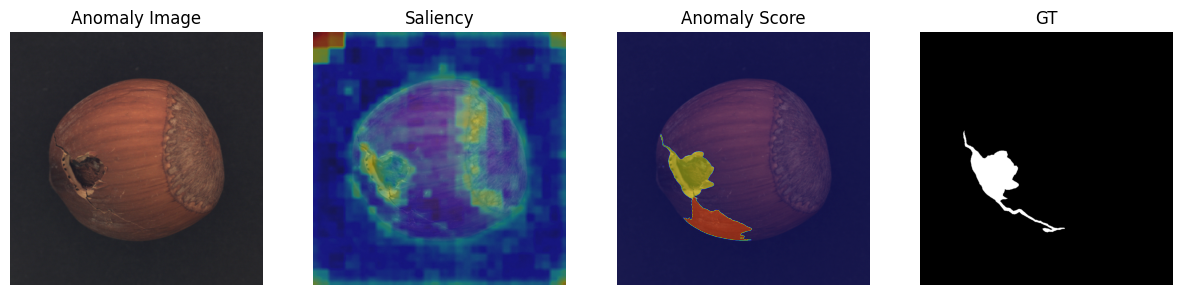

In [16]:
# saa+
textual_prompts = manual_prompts[main_name]
property_text_prompts =  property_prompts[main_name]

saa_image = cv2.imread(image_path)
saa_model.set_ensemble_text_prompts(textual_prompts, verbose=False)
saa_model.set_property_text_prompts(property_text_prompts, verbose=False)
score, appendix = saa_model(saa_image)

similarity_map = appendix['similarity_map']
similarity_map = cv2.resize(similarity_map, (raw_image.size[0], raw_image.size[1]))

saa_mask = cv2.resize(score, (raw_image.size[0], raw_image.size[1]))
saa_mask = saa_mask > 0

plt.figure(figsize=(15, 7))
plt.subplot(141)
plt.imshow(raw_image)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(raw_image)
plt.imshow(similarity_map, alpha=0.4, cmap='jet')
plt.axis('off') 
plt.title('Saliency')

plt.subplot(143)
plt.imshow(raw_image)
plt.imshow(score, alpha=0.4,cmap='jet')
plt.axis('off') 
plt.title('Anomaly Score')

plt.subplot(144)
plt.imshow(gt_image)
# plt.imshow(score, alpha=0.3, cmap='jet')
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/saa+/saa+_{}_{}_{}.png'.format(main_name, sub_name, sub_number), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 2. naive prompt

text_prompt :  defect
['defect(0.75)']
GroundingDINO finished
Before NMS: 1 boxes
After NMS: 1 boxes
1 times enlarged boxes:  tensor([[154.7706, 184.6122, 870.4783, 847.8236]])
SAM finished


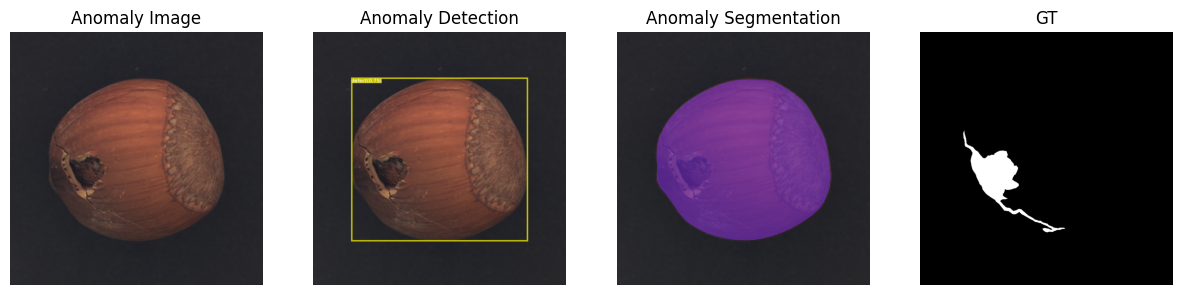

In [17]:
# Set TEXT_PROMPT
TEXT_PROMPT = "defect"
print('text_prompt : ', TEXT_PROMPT)

# Run GroundedSAM
masks, boxes_filt, pred_phrases, _ = GroundedSAM(grounding_dino_model, sam_model, 
                                                      image, source_image, raw_image, 
                                                      box_threshold1, box_threshold2, text_threshold, 
                                                      TEXT_PROMPT, DEVICE)
#Draw Box
box_image = raw_image.copy()
box_draw = ImageDraw.Draw(box_image)
for box, label in zip(boxes_filt, pred_phrases):
    draw_box(box, box_draw, label)
box_image_show = np.array(box_image)

#Draw Mask
mask_image = Image.new('RGBA', (raw_image.size[0], raw_image.size[1]), color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
for mask in masks:
    draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)
mask_image_show = np.array(mask_image)

#Sum Mask
naive_mask = sum(masks[i][0] for i in range(len(masks)))
naive_mask = naive_mask > 0

plt.figure(figsize=(15, 7))
plt.subplot(141)
plt.imshow(raw_image)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(box_image_show)
plt.axis('off') 
plt.title('Anomaly Detection')

plt.subplot(143)
plt.imshow(raw_image)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('Anomaly Segmentation')

plt.subplot(144)
plt.imshow(gt_image)
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/naive/naive_{}_{}_{}.png'.format(main_name, sub_name, sub_number), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 3. RAM prompt

Tags:  acorn, chestnut, crack, hazelnut, hole, nut, peel, shell, tear
RAM finished
text_prompt :  acorn, chestnut, crack, hazelnut, hole, nut, peel, shell, tear
['acorn hazelnut(0.40)', 'acorn(0.25)', 'shell(0.25)', 'acorn(0.35)', 'acorn(0.21)', 'crack(0.26)', 'chestnut(0.20)', 'acorn(0.21)']
GroundingDINO finished
Before NMS: 8 boxes
After NMS: 5 boxes
1 times enlarged boxes:  tensor([[152.6430, 183.6906, 871.8496, 848.5367],
        [300.4954, 634.2356, 552.0957, 808.6045],
        [172.5133, 406.2794, 397.7946, 666.6602],
        [168.9264, 404.2692, 552.9703, 810.4883],
        [244.4740, 482.0436, 394.4380, 634.5013]])
SAM finished


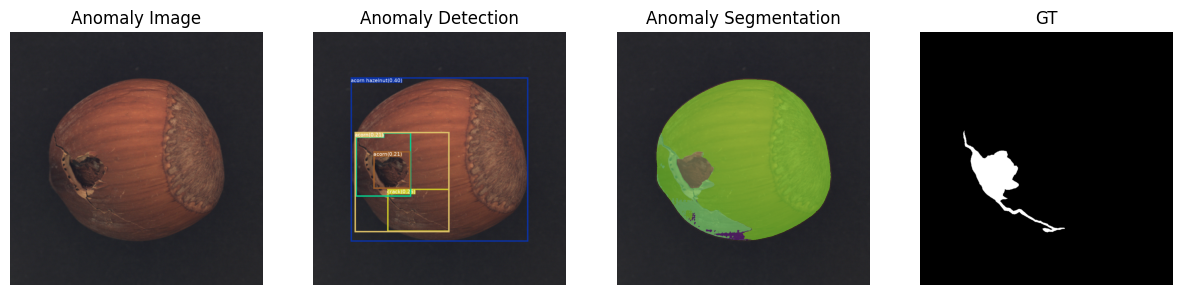

In [18]:
# Run ram model
res = inference_ram(ram_image.to(DEVICE), ram_model)
tags = res[0].strip(' ').replace('  ', ' ').replace(' |', ',')
print("Tags: ", tags)
print('RAM finished')

# Set TEXT_PROMPT
TEXT_PROMPT = tags
print('text_prompt : ', TEXT_PROMPT)

# Run GroundedSAM
masks, boxes_filt, pred_phrases, _ = GroundedSAM(grounding_dino_model, sam_model, 
                                                      image, source_image, raw_image, 
                                                      box_threshold1, box_threshold2, text_threshold, 
                                                      TEXT_PROMPT, DEVICE)

#Draw Box
box_image = raw_image.copy()
box_draw = ImageDraw.Draw(box_image)
for box, label in zip(boxes_filt, pred_phrases):
    draw_box(box, box_draw, label)
box_image_show = np.array(box_image)

#Draw Mask
mask_image = Image.new('RGBA', (raw_image.size[0], raw_image.size[1]), color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
for mask in masks:
    draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)
mask_image_show = np.array(mask_image)

#Sum Mask
ram_mask = sum(masks[i][0] for i in range(len(masks)))
ram_mask = ram_mask > 0

plt.figure(figsize=(15, 7))
plt.subplot(141)
plt.imshow(raw_image)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(box_image_show)
plt.axis('off') 
plt.title('Anomaly Detection')

plt.subplot(143)
plt.imshow(raw_image)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('Anomaly Segmentation')

plt.subplot(144)
plt.imshow(gt_image)
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/ram/ram_{}_{}_{}.png'.format(main_name, sub_name, sub_number), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 4. RAM + BB

Tags:  acorn, chestnut, crack, hazelnut, hole, nut, peel, shell, tear
RAM finished
text_prompt :  acorn, chestnut, crack, hazelnut, hole, nut, peel, shell, tear
['acorn hazelnut(0.40)', 'acorn(0.25)', 'shell(0.25)', 'acorn(0.35)', 'acorn(0.21)', 'crack(0.26)', 'chestnut(0.20)', 'acorn(0.21)']
GroundingDINO finished
Before NMS: 8 boxes
After NMS: 5 boxes
Original boxes:  tensor([[152.6430, 183.6906, 871.8496, 848.5367],
        [300.4954, 634.2356, 552.0957, 808.6045],
        [172.5133, 406.2794, 397.7946, 666.6602],
        [168.9264, 404.2692, 552.9703, 810.4883],
        [244.4740, 482.0436, 394.4380, 634.5013]])
1.3 times enlarged boxes:  tensor([[ 44.7621,  83.9637, 979.7306, 948.2636],
        [262.7553, 608.0803, 589.8358, 834.7598],
        [138.7211, 367.2222, 431.5867, 705.7173],
        [111.3198, 343.3364, 610.5769, 871.4211],
        [221.9794, 459.1749, 416.9326, 657.3700]])
SAM finished


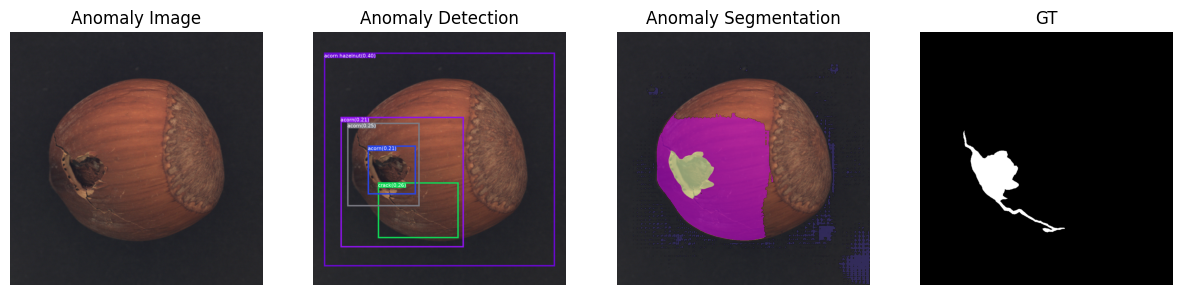

In [19]:
# Run ram model
res = inference_ram(ram_image.to(DEVICE), ram_model)
tags = res[0].strip(' ').replace('  ', ' ').replace(' |', ',')
print("Tags: ", tags)
print('RAM finished')

# Set TEXT_PROMPT
TEXT_PROMPT = tags
print('text_prompt : ', TEXT_PROMPT)

# Run GroundedSAM
masks, boxes_filt, pred_phrases, _ = GroundedSAM(grounding_dino_model, sam_model, 
                                                      image, source_image, raw_image, 
                                                      box_threshold1, box_threshold2, text_threshold, 
                                                      TEXT_PROMPT, DEVICE, filt_bb)

#Draw Box
box_image = raw_image.copy()
box_draw = ImageDraw.Draw(box_image)
for box, label in zip(boxes_filt, pred_phrases):
    draw_box(box, box_draw, label)
box_image_show = np.array(box_image)

#Draw Mask
mask_image = Image.new('RGBA', (raw_image.size[0], raw_image.size[1]), color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
for mask in masks:
    draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)
mask_image_show = np.array(mask_image)

#Sum Mask
ram_bb_mask = sum(masks[i][0] for i in range(len(masks)))
ram_bb_mask = ram_bb_mask > 0

plt.figure(figsize=(15, 7))
plt.subplot(141)
plt.imshow(raw_image)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(box_image_show)
plt.axis('off') 
plt.title('Anomaly Detection')

plt.subplot(143)
plt.imshow(raw_image)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('Anomaly Segmentation')

plt.subplot(144)
plt.imshow(gt_image)
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/ram+bb/ram_bb_{}_{}_{}.png'.format(main_name, sub_name, sub_number), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 5. RAM + BB +IPA

Tags:  acorn, chestnut, crack, hazelnut, hole, nut, peel, shell, tear
RAM finished
text_prompt :  acorn, chestnut, crack, hazelnut, hole, nut, peel, shell, tear
['acorn hazelnut(0.40)', 'acorn(0.25)', 'shell(0.25)', 'acorn(0.35)', 'acorn(0.21)', 'crack(0.26)', 'chestnut(0.20)', 'acorn(0.21)']
GroundingDINO finished
Before NMS: 8 boxes
After NMS: 5 boxes
Original boxes:  tensor([[152.6430, 183.6906, 871.8496, 848.5367],
        [300.4954, 634.2356, 552.0957, 808.6045],
        [172.5133, 406.2794, 397.7946, 666.6602],
        [168.9264, 404.2692, 552.9703, 810.4883],
        [244.4740, 482.0436, 394.4380, 634.5013]])
1.3 times enlarged boxes:  tensor([[ 44.7621,  83.9637, 979.7306, 948.2636],
        [262.7553, 608.0803, 589.8358, 834.7598],
        [138.7211, 367.2222, 431.5867, 705.7173],
        [111.3198, 343.3364, 610.5769, 871.4211],
        [221.9794, 459.1749, 416.9326, 657.3700]])
SAM finished


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.57it/s]
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
100%|██████████| 50/50 [00:01<00:00, 32.86it/s]


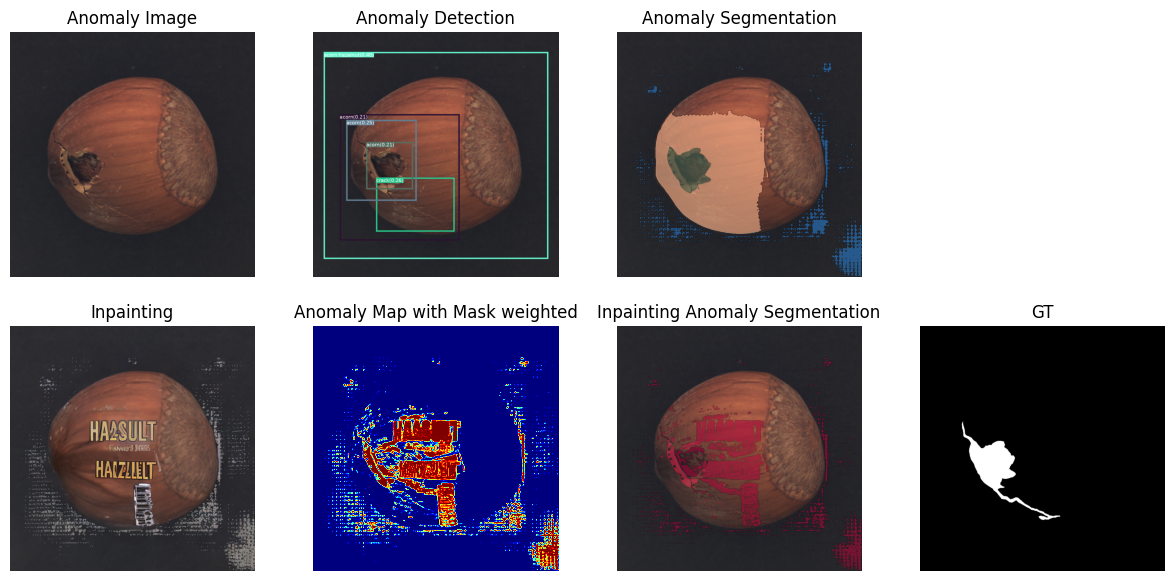

In [20]:
# Run ram model
res = inference_ram(ram_image.to(DEVICE), ram_model)
tags = res[0].strip(' ').replace('  ', ' ').replace(' |', ',')
print("Tags: ", tags)
print('RAM finished')

# Set TEXT_PROMPT
TEXT_PROMPT = tags
print('text_prompt : ', TEXT_PROMPT)

# Run GroundedSAM
masks, boxes_filt, pred_phrases, scores_filt = GroundedSAM(grounding_dino_model, sam_model, 
                                                      image, source_image, raw_image, 
                                                      box_threshold1, box_threshold2, text_threshold, 
                                                      TEXT_PROMPT, DEVICE, filt_bb)

# Run Inpainting
inpainting_image, anomaly_map = inpainting(source_image, image_path, DEVICE,
                                           boxes_filt, scores_filt, pred_phrases, masks, 
                                           main_name, sub_name, sub_number, 
                                           inpainting_diff_threshold)

#Draw Box
box_image = raw_image.copy()
box_draw = ImageDraw.Draw(box_image)
for box, label in zip(boxes_filt, pred_phrases):
    draw_box(box, box_draw, label)
box_image_show = np.array(box_image)

#Draw Mask
mask_image = Image.new('RGBA', (raw_image.size[0], raw_image.size[1]), color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
for mask in masks:
    draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)
mask_image_show = np.array(mask_image)

#Draw Mask
inpainting_mask_image = Image.new('RGBA', (raw_image.size[0], raw_image.size[1]), color=(0, 0, 0, 0))
inpainting_mask_draw = ImageDraw.Draw(inpainting_mask_image)
draw_mask(anomaly_map, inpainting_mask_draw, random_color=True)
inpainting_mask_image_show = np.array(inpainting_mask_image)

#Sum Mask
ram_bb_ipa_mask = anomaly_map
ram_bb_ipa_mask = ram_bb_ipa_mask > 0

plt.figure(figsize=(15, 7))
plt.subplot(241)
plt.imshow(raw_image)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(242)
plt.imshow(box_image_show)
plt.axis('off') 
plt.title('Anomaly Detection')

plt.subplot(243)
plt.imshow(raw_image)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('Anomaly Segmentation')

plt.subplot(245)
plt.imshow(inpainting_image)
plt.axis('off') 
plt.title('Inpainting')

plt.subplot(246)
plt.imshow(raw_image)
plt.imshow(anomaly_map, cmap='jet')
plt.axis('off') 
plt.title('Anomaly Map with Mask weighted')

plt.subplot(247)
plt.imshow(raw_image)
plt.imshow(inpainting_mask_image_show)
plt.axis('off') 
plt.title('Inpainting Anomaly Segmentation')

plt.subplot(248)
plt.imshow(gt_image)
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/ram+bb+ipa/ram_bb_ipa{}_{}_{}.png'.format(main_name, sub_name, sub_number), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 6. RAM + LLM + BB

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Tags:  acorn, chestnut, crack, hazelnut, hole, nut, peel, shell, tear
RAM finished
Tags :  broken crack, misshapen acorn, cracked hazelnut, torn peel, damaged shell, unusual nut, irregular hole, deformed chestnut.
Llama3 finished
text_prompt :  broken crack, misshapen acorn, cracked hazelnut, torn peel, damaged shell, unusual nut, irregular hole, deformed chestnut.
['broken crack hazelnut(0.39)', 'unusual nut irregular hole(0.36)', 'chestnut(0.23)', 'shell chestnut(0.28)', 'broken crack(0.32)', 'broken crack(0.25)', 'broken crack(0.30)', 'irregular hole(0.25)', 'unusual(0.20)', 'torn peel shell(0.30)', 'irregular hole(0.21)']
GroundingDINO finished
Before NMS: 11 boxes
After NMS: 6 boxes
Original boxes:  tensor([[152.4015, 183.7390, 872.8525, 849.1562],
        [244.1685, 483.7283, 395.3402, 636.9355],
        [169.3018, 403.7074, 554.8126, 811.8521],
        [613.3012, 196.6774, 870.6598, 738.0599],
        [297.0578, 630.9042, 554.8623, 810.2726],
        [261.6281, 478.4800, 355.338

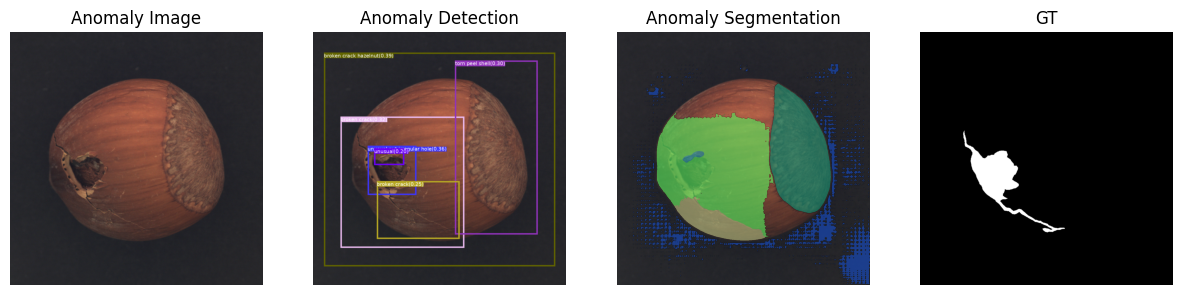

In [22]:
# Run ram model
res = inference_ram(ram_image.to(DEVICE), ram_model)
tags = res[0].strip(' ').replace('  ', ' ').replace(' |', ',')
print("Tags: ", tags)
print('RAM finished')

# Run Llama3
llama_tags = anomaly_llama(llama_tokenizer, llama_model, tags) 
print('Llama3 finished')

# Set TEXT_PROMPT
TEXT_PROMPT = llama_tags
print('text_prompt : ', TEXT_PROMPT)

# Run GroundedSAM
masks, boxes_filt, pred_phrases, _ = GroundedSAM(grounding_dino_model, sam_model, 
                                                      image, source_image, raw_image, 
                                                      box_threshold1, box_threshold2, text_threshold, 
                                                      TEXT_PROMPT, DEVICE, filt_bb)

#Draw Box
box_image = raw_image.copy()
box_draw = ImageDraw.Draw(box_image)
for box, label in zip(boxes_filt, pred_phrases):
    draw_box(box, box_draw, label)
box_image_show = np.array(box_image)

#Draw Mask
mask_image = Image.new('RGBA', (raw_image.size[0], raw_image.size[1]), color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
for mask in masks:
    draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)
mask_image_show = np.array(mask_image)
#Sum Mask
ram_llm_bb_mask = sum(masks[i][0] for i in range(len(masks)))
ram_llm_bb_mask = ram_llm_bb_mask > 0

plt.figure(figsize=(15, 7))
plt.subplot(141)
plt.imshow(raw_image)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(box_image_show)
plt.axis('off') 
plt.title('Anomaly Detection')

plt.subplot(143)
plt.imshow(raw_image)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('Anomaly Segmentation')

plt.subplot(144)
plt.imshow(gt_image)
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/ram+llm+bb/ram_llm_bb_{}_{}_{}.png'.format(main_name, sub_name, sub_number), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 7. RAM + LLM + BB + IPA

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Tags:  acorn, chestnut, crack, hazelnut, hole, nut, peel, shell, tear
RAM finished
Tags :  abnormal acorn, broken chestnut, cracked crack, misshapen hazelnut, empty hole, rotten nut, damaged peel, broken shell, torn tear
Llama3 finished
text_prompt :  abnormal acorn, broken chestnut, cracked crack, misshapen hazelnut, empty hole, rotten nut, damaged peel, broken shell, torn tear
['abnormal acorn broken chestnut(0.31)', 'broken shell(0.49)', 'cracked crack(0.35)', 'hazelnut empty hole rotten nut(0.34)', 'damaged peel(0.34)', 'peel(0.24)', 'empty hole(0.22)', 'broken shell(0.26)', 'empty hole(0.21)', 'crack(0.23)']
GroundingDINO finished
Before NMS: 10 boxes
After NMS: 6 boxes
Original boxes:  tensor([[152.3620, 184.5811, 872.3442, 849.8793],
        [298.6847, 634.3625, 554.5753, 810.6936],
        [243.7949, 483.1738, 395.9034, 637.0634],
        [613.1266, 195.4783, 870.9618, 738.7380],
        [170.7766, 405.0757, 554.6053, 810.9351],
        [171.6700, 405.8444, 399.3367, 678.8103]]

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.13it/s]
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
100%|██████████| 50/50 [00:01<00:00, 35.41it/s]


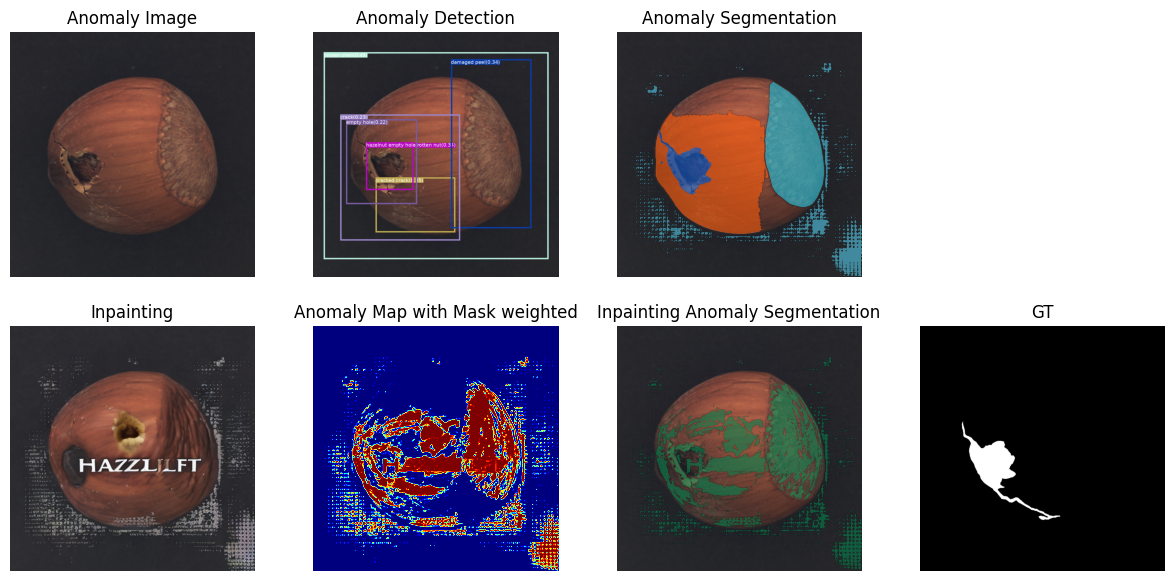

In [23]:
# Run ram model
res = inference_ram(ram_image.to(DEVICE), ram_model)
tags = res[0].strip(' ').replace('  ', ' ').replace(' |', ',')
print("Tags: ", tags)
print('RAM finished')

# Run Llama3
llama_tags = anomaly_llama(llama_tokenizer, llama_model, tags) 
print('Llama3 finished')

# Set TEXT_PROMPT
TEXT_PROMPT = llama_tags
print('text_prompt : ', TEXT_PROMPT)

# Run GroundedSAM
masks, boxes_filt, pred_phrases, scores_filt = GroundedSAM(grounding_dino_model, sam_model, 
                                                      image, source_image, raw_image, 
                                                      box_threshold1, box_threshold2, text_threshold, 
                                                      TEXT_PROMPT, DEVICE, filt_bb)

# Run Inpainting
inpainting_image, anomaly_map = inpainting(source_image, image_path, DEVICE,
                                           boxes_filt, scores_filt, pred_phrases, masks, 
                                           main_name, sub_name, sub_number, 
                                           inpainting_diff_threshold)

#Draw Box
box_image = raw_image.copy()
box_draw = ImageDraw.Draw(box_image)
for box, label in zip(boxes_filt, pred_phrases):
    draw_box(box, box_draw, label)
box_image_show = np.array(box_image)

#Draw Mask
mask_image = Image.new('RGBA', (raw_image.size[0], raw_image.size[1]), color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
for mask in masks:
    draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)
mask_image_show = np.array(mask_image)

#Draw Mask
inpainting_mask_image = Image.new('RGBA', (raw_image.size[0], raw_image.size[1]), color=(0, 0, 0, 0))
inpainting_mask_draw = ImageDraw.Draw(inpainting_mask_image)
draw_mask(anomaly_map, inpainting_mask_draw, random_color=True)
inpainting_mask_image_show = np.array(inpainting_mask_image)

#Sum Mask
ram_llm_bb_ipa_mask = anomaly_map
ram_llm_bb_ipa_mask = ram_llm_bb_ipa_mask > 0

plt.figure(figsize=(15, 7))
plt.subplot(241)
plt.imshow(raw_image)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(242)
plt.imshow(box_image_show)
plt.axis('off') 
plt.title('Anomaly Detection')

plt.subplot(243)
plt.imshow(raw_image)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('Anomaly Segmentation')

plt.subplot(245)
plt.imshow(inpainting_image)
plt.axis('off') 
plt.title('Inpainting')

plt.subplot(246)
plt.imshow(raw_image)
plt.imshow(anomaly_map, cmap='jet')
plt.axis('off') 
plt.title('Anomaly Map with Mask weighted')

plt.subplot(247)
plt.imshow(raw_image)
plt.imshow(inpainting_mask_image_show)
plt.axis('off') 
plt.title('Inpainting Anomaly Segmentation')

plt.subplot(248)
plt.imshow(gt_image)
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/ram+llm+bb+ipa/ram_llm_bb_ipa{}_{}_{}.png'.format(main_name, sub_name, sub_number), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 8. Compare

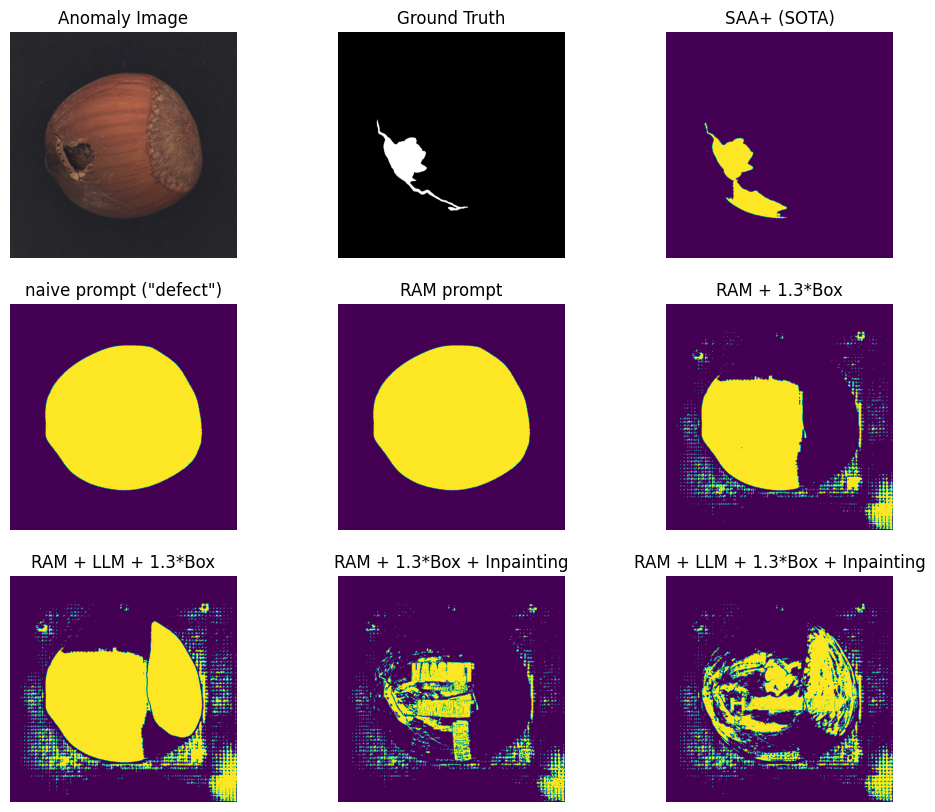

In [24]:
plt.figure(figsize=(12, 10))
plt.subplot(331)
plt.imshow(raw_image)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(332)
plt.imshow(gt_image)
plt.axis('off') 
plt.title('Ground Truth')

plt.subplot(333)
plt.imshow(saa_mask)
plt.axis('off') 
plt.title('SAA+ (SOTA)')

plt.subplot(334)
plt.imshow(naive_mask.cpu().numpy())
plt.axis('off') 
plt.title('naive prompt ("defect")')

plt.subplot(335)
plt.imshow(ram_mask.cpu().numpy())
plt.axis('off') 
plt.title('RAM prompt')

plt.subplot(336)
plt.imshow(ram_bb_mask.cpu().numpy())
plt.axis('off') 
plt.title(f'RAM + {filt_bb}*Box')

plt.subplot(337)
plt.imshow(ram_llm_bb_mask.cpu().numpy())
plt.axis('off') 
plt.title(f'RAM + LLM + {filt_bb}*Box')

plt.subplot(338)
plt.imshow(ram_bb_ipa_mask)
plt.axis('off') 
plt.title(f'RAM + {filt_bb}*Box + Inpainting')

plt.subplot(339)
plt.imshow(ram_llm_bb_ipa_mask)
plt.axis('off') 
plt.title(f'RAM + LLM + {filt_bb}*Box + Inpainting')

plt.savefig('./results_image/compare/compare_{}_{}_{}.png'.format(main_name, sub_name, sub_number), bbox_inches='tight', pad_inches=0.1)
plt.show()